In [39]:
# ALL IMPORTS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import qutip as qt
import scipy.constants as const

from IPython import display

import os
import imageio.v2 as imageio

import math
from scipy.special import genlaguerre

0.0


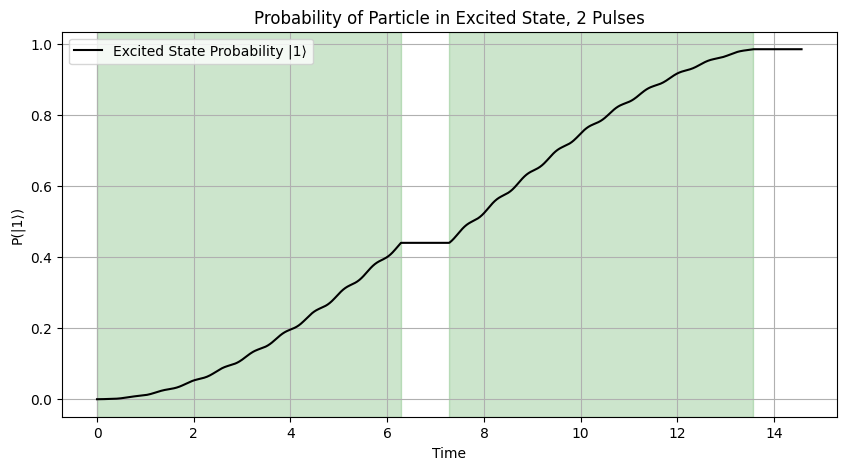

In [25]:
# Basis states
g = qt.basis(2,1)
e = qt.basis(2,0)

g_exp = g * g.dag()
e_exp = e * e.dag()

# parameters
w = 5.0
wl = 5.0      
wr = 0.25    
phi = np.pi/4      

# Define parameters
num_pulses = 2   # Number of pulse cycles
T_idle = 1       # Idle time after each pulse
T_pulse = np.pi/(2*wr)  # Duration of each pulse
T_cycle = T_pulse + T_idle  # Total time per cycle
total_time = num_pulses * T_cycle  # Total simulation time
# delta = w - wl
# T_idle = np.pi/(4 * delta)

# wl = w - delta
print(delta)

n_steps = 1000  # Higher resolution for better plotting
t = np.linspace(0, total_time, n_steps)  # Time array

def pulse_window(t):
    """Returns 1 during pulse times and 0 during idle times."""
    return any((k * T_cycle <= t < k * T_cycle + T_pulse) for k in range(num_pulses))

def solve_hamiltonian(wl, wr, w, phi, initial_state):
    """Solves the Hamiltonian evolution over multiple pulses."""
    # Static Hamiltonian
    H0 = .5 * wl * qt.sigmaz()
    H1 = .5 * wr * qt.sigmax()
    H2 = .5 * wr * qt.sigmay()

    # Time-dependent coefficients
    def H1_coeff(t, args):
        return pulse_window(t) * np.cos(w*t + phi)  # Active only during pulses

    def H2_coeff(t, args):
        return pulse_window(t) * np.sin(w*t + phi + np.pi/4)  # Active only during pulses

    # Full Hamiltonian with time dependence
    H = [H0, [H1, H1_coeff], [H2, H2_coeff]]

    # Solve the Schrödinger equation
    result = qt.mesolve(H, initial_state, t, [], [g_exp])
    return result.expect[0]  # Expectation value of |1⟩ (excited state)

initial_state = e  # Start in ground state |0>

excited_prob = solve_hamiltonian(wl, wr, w, phi, initial_state)

# Plot the results
plt.figure(figsize=(10,5))
plt.plot(t, excited_prob, label="Excited State Probability |1⟩", color="k")

# Shade pulse regions
for k in range(num_pulses):
    plt.axvspan(k * T_cycle, k * T_cycle + T_pulse, color='green', alpha=0.2)

plt.xlabel("Time")
plt.ylabel("P(|1⟩)")
plt.title(f"Probability of Particle in Excited State, {num_pulses} Pulses")
plt.legend()
plt.grid()
plt.show()


In [ ]:

# Define basis states
g = qt.basis(2,1)  # |1⟩ (Excited state)
e = qt.basis(2,0)  # |0⟩ (Ground state)

g_exp = g * g.dag()  # Projection operator for excited state

# Define system parameters
wl = 5.0      # Energy splitting
wr = 10       # Driving amplitude (Rabi frequency)
w = 5.1       # Driving frequency (small detuning)
phi = 0       # Phase shift

# Compute detuning
delta = w - wl  # Detuning (assumed small for Ramsey)

# Define pulse and idle parameters
T_pulse = np.pi / (2 * wr)  # Duration of a π/2 pulse
T_max = 2 * np.pi / delta   # Maximum idle time (for ∆ * Tmax = 2π)
idle_times = np.linspace(0, T_max, 100)  # Range of idle times

def apply_ramsey_pulses(wl, wr, w, phi, idle_time):
    """Simulates a Ramsey experiment with a given idle time."""
    
    # Define Hamiltonians
    H0 = 0.5 * wl * qt.sigmaz()  # Static Hamiltonian during free evolution
    H_drive = 0.5 * wr * (qt.sigmax() * np.cos(w * 0 + phi) + qt.sigmay() * np.sin(w * 0 + phi))  # π/2 pulse Hamiltonian

    # Solve for first π/2 pulse
    result1 = qt.mesolve(H_drive, e, [0, T_pulse], [], [])
    state_after_pulse1 = result1.states[-1]

    # Solve for free evolution during idle time
    result_idle = qt.mesolve(H0, state_after_pulse1, [0, idle_time], [], [])
    state_after_idle = result_idle.states[-1]

    # Solve for second π/2 pulse
    result2 = qt.mesolve(H_drive, state_after_idle, [0, T_pulse], [], [g_exp])
    
    return result2.expect[0][-1]  # Excited state probability after second π/2 pulse

# Compute excited state probabilities for each idle time
excited_probabilities = [apply_ramsey_pulses(wl, wr, w, phi, T) for T in idle_times]

# Plot the Ramsey fringes
plt.figure(figsize=(8,5))
plt.plot(idle_times, excited_probabilities, color='b')
plt.xlabel("Idle Time T")
plt.ylabel("Excited State Probability P_e")
plt.title("Ramsey Interferometry: Excited State Probability vs Idle Time")
plt.grid()
plt.legend()
plt.show()

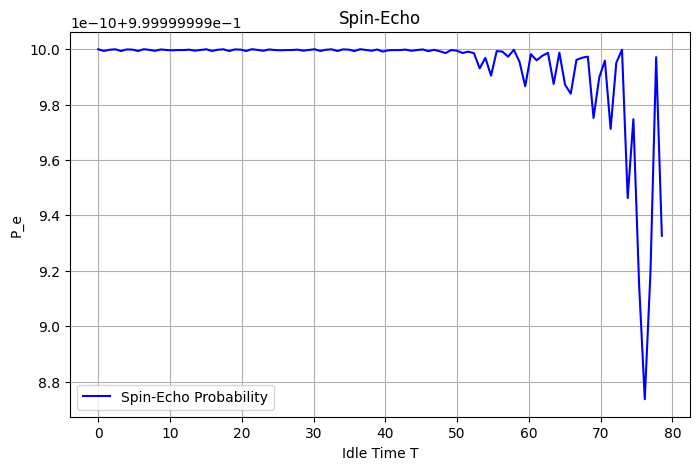

In [38]:
# Define basis states
g = qt.basis(2,1)  # |1⟩ (Excited state)
e = qt.basis(2,0)  # |0⟩ (Ground state)

g_exp = g * g.dag()  # Projection operator for excited state

# Define system parameters
wl = 5.0      # Energy splitting
wr = 10       # Driving amplitude (Rabi frequency)
w = 5.08       # Driving frequency (small detuning)
phi_0 = 0     # Phase for outer π/2 pulses
phi_pi = np.pi / 2  # Phase for π pulse

# Compute detuning
delta = w - wl  # Detuning (assumed small for Ramsey)

# Define pulse and idle parameters
T_pulse = np.pi / (2 * wr)  # Duration of a π/2 pulse
T_pi_pulse = np.pi / wr     # Duration of a π pulse
T_max = 2 * np.pi / delta   # Maximum idle time (for ∆ * Tmax = 2π)
idle_times = np.linspace(0, T_max, 100)  # Range of idle times

def apply_spin_echo_ramsey_pulses(wl, wr, w, idle_time):
    """Simulates a Ramsey experiment with a spin-echo π-pulse in the middle."""

    # Define Hamiltonians
    H0 = 0.5 * wl * qt.sigmaz()  # Static Hamiltonian during free evolution
    H_pi2 = 0.5 * wr * (qt.sigmax() * np.cos(phi_0) + qt.sigmay() * np.sin(phi_0))  # π/2 pulse Hamiltonian
    H_pi = 0.5 * wr * (qt.sigmax() * np.cos(phi_pi) + qt.sigmay() * np.sin(phi_pi))  # π pulse Hamiltonian

    # Solve for first π/2 pulse
    result1 = qt.mesolve(H_pi2, e, [0, T_pulse], [], [])
    state_after_pulse1 = result1.states[-1]

    # Solve for free evolution during first idle time (T/2)
    result_idle1 = qt.mesolve(H0, state_after_pulse1, [0, idle_time / 2], [], [])
    state_after_idle1 = result_idle1.states[-1]

    # Solve for π pulse
    result_pi = qt.mesolve(H_pi, state_after_idle1, [0, T_pi_pulse], [], [])
    state_after_pi = result_pi.states[-1]

    # Solve for free evolution during second idle time (T/2)
    result_idle2 = qt.mesolve(H0, state_after_pi, [0, idle_time / 2], [], [])
    state_after_idle2 = result_idle2.states[-1]

    # Solve for final π/2 pulse
    result2 = qt.mesolve(H_pi2, state_after_idle2, [0, T_pulse], [], [g_exp])
    
    return result2.expect[0][-1]  # Excited state probability after final π/2 pulse

# Compute excited state probabilities for each idle time
excited_probabilities = [apply_spin_echo_ramsey_pulses(wl, wr, w, T) for T in idle_times]

# Plot the results
plt.figure(figsize=(8,5))
plt.plot(idle_times, excited_probabilities, label="Spin-Echo Probability", color= 'b')
plt.xlabel("Idle Time T")
plt.ylabel("P_e")
plt.title("Spin-Echo")


plt.grid()
plt.legend()
plt.show()







In [ ]:

# if not os.path.exists('tmp'):
#     os.mkdir('tmp')

# def bloch_results(result, n):
#     sphere = qt.Bloch()
#     sphere.vector_color = ["r"]

#     sphere.clear()
#     sphere.add_vectors([result.expect[0][n],
#                         result.expect[1][n],
#                         result.expect[2][n]])
#     sphere.add_points(
#         [
#             result.expect[0][: n + 1],
#             result.expect[1][: n + 1],
#             result.expect[2][: n + 1],
#         ],
#         meth="l",
#     )
#     return(sphere)

# def animate_results(results, title, n_steps):
#     try:
#         os.mkdir('tmp')
#     except:
#         pass
#     # Get bloch data
#     bloch = [bloch_results(result, i) for i in range(n_steps)]
#     # export PNG images
#     for i in range(n_steps):
#         print(f'Exporting PNG image... {i}/{n_steps}', end='\r')
#         bloch[i].make_sphere()
#         bloch[i].fig.savefig(f'tmp/_{title}-{i}.png') 
#     # Create animation
#     print('Creating animation...')
#     ims = [imageio.imread(f'tmp/_{title}-{i}.png') for i in range(n_steps)]
#     imageio.mimwrite(f'{title}.gif', ims, fps=10)
#     show_animation(filename=f'{title}.gif')

# def show_animation(filename):
#     return display.Image(filename=filename)


# n_steps = 50
# result = solve_hamiltonian(1,0.5,1.75, g, [qt.sigmax(), qt.sigmay(), qt.sigmaz()])
# animate_results(result, "c_ex", n_steps=n_steps)

# n_steps = 50
# result = solve_hamiltonian(1,0,0, g, [qt.sigmax(), qt.sigmay(), qt.sigmaz()])
# animate_results(result, "c", n_steps=n_steps)

# result = solve_hamiltonian(np.pi,1,np.pi,g,[qt.sigmax(), qt.sigmay(), qt.sigmaz()])
# animate_results(result, "e", n_steps=n_steps)

# def solve_hamiltonian_I(wl,wr,w,initial,expectations=[]):
#   H = ((wl-w) * qt.sigmaz() + wr * qt.sigmax())
#   return qt.mesolve(H, initial, t, [], expectations)

# result = solve_hamiltonian_I(np.pi,1,np.pi,g, [qt.sigmax(), qt.sigmay(), qt.sigmaz()])
# animate_results(result, "g", n_steps=n_steps)


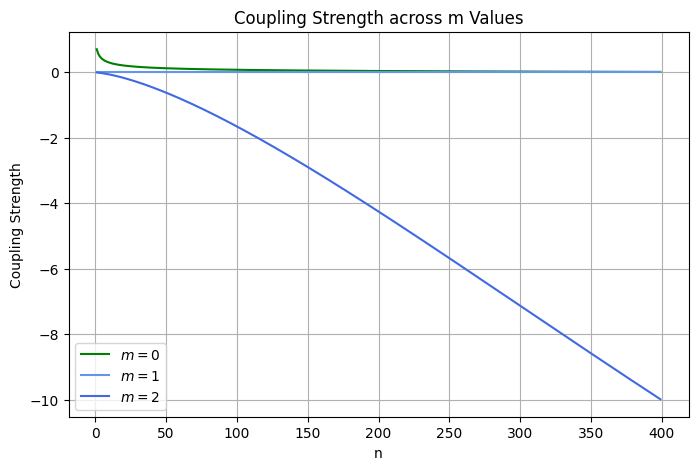

In [49]:


# Define the strength function
def strength(n, m):
    L_nm = genlaguerre(n, m)  # Generate L_n^m(x)
    return np.real(np.exp(-((0.05)**2)/2) * np.sqrt(math.factorial(m)/(n + math.factorial(m))) * (1j * 0.05)**m * L_nm((0.05)**2))

# Define n and m values
n_vals = np.arange(1, 400, 1)  # Integer values from 0 to 499
m_vals = [0, 1, 2]  # Different m values
cols = ['g', 'cornflowerblue', 'royalblue']

# Plot each curve for different m values
plt.figure(figsize=(8, 5))
for m in m_vals:
    y_vals = [strength(n, m) for n in n_vals]  # Compute strength for each n
    plt.plot(n_vals, y_vals, label=rf'$m={m}$', color=cols[m])

# Formatting
plt.xlabel('n')
plt.ylabel('Coupling Strength')
plt.title('Coupling Strength across m Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
